# Paso 1.
Primero adjunté el archivo csv a este project para poder leerlo y trabajar con el.

# Paso 2. 

In [140]:
# Importación de librerías 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# Lectura de archivo csv para leer los DataFrames
df = pd.read_csv("games.csv")

In [56]:
# Impresión de primera vista respecto a games.csv
print(df)
print()
df.info()

                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        Sports   
16712        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16713               Spirits & Spells      GBA           2003.0      Platform   
16714            Winning Post 8 2016      PSV           2016.0    Simulation   

       NA_sales  EU_sales  JP_sales  Ot

Verificamos la información, los nombres de las columnas y las filas que contiene el df y observamos que ya anteriormente habíamos trabajado un poco con este df anteriormente. 
1. Observamos primero que el nombre de las columnas no es el mejor, podemos poner todo en minúscula.
2. Se encuentran valores ausentes en columnas como Critic_Score, User_Score y Rating. En otras columnas, hay valores iguales a 0 pero esos son de valor para nosotros para poder trabajar con esos datos.
3. Hay datos que debemos de cambiar, por ejemplo en User_Score y Rating, deberían ser datos de tipo flotante, year_of_release es foat en lugar de int. 
4. También hay 2 valores nulos en el nombre de juego, que significa esto?, juegos sin nombre o algun a otra representación.
5. 

In [57]:
# Reemplazo de nombres en minúscula
df.columns = df.columns.str.lower()
print(df.columns) # Corroboramos que si se haya cambiado

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


In [58]:
# Cambio de tipo para las columnas que lo necesiten 
df["year_of_release"] = df["year_of_release"].astype("Int64") #Cambio de year_of_release a int
df["user_score"] = df["user_score"].replace("tbd", np.nan) # Cambiamos los dos valores llamados tbd a NA 
df["user_score"] = pd.to_numeric(df["user_score"], errors = "coerce")

# Cambiamos el tipo de dato a las otras columnas

df["name"] = df["name"].astype("string")
df["platform"] = df["platform"].astype("string")
df["genre"] = df["genre"].astype("string")
df["rating"] = df["rating"].astype("string")
df.info() # Comprobamos que se hayan realizado los cambios

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  string 
 1   platform         16715 non-null  string 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  string 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   string 
dtypes: Int64(1), float64(6), string(4)
memory usage: 1.4 MB


## Justificación de cambio de tipos de datos
- En la columna year_of_release cambiamos los años ya que los valores son enteros. 
- En la columna user_score cambiamos de object a float para los puntajes ya que son valores numéricos con decimal. 
- En la columna name, genre, platform, genre y rating cambiamos de object a string, porque son valores textuales, he conocido mayor cantidad de métodos de manipulación de strings.
- No se podificaron na_sales, eu_sales, jp_sales y other_sales debido a que las ventas es en millones y son valores decimales apropiados para float.
- critic score se mantiene por que los valores son decimales. 

## Análisis de valores ausentes y que estretegia tomar
- En la columna name y genre cuentan con 2 valores ausentes, es un significado mínimo para nuestros datos, ya que son una gran cantidad de columnas, por lo tanto voy a optar por eliminar estas columnas, ya que no tiene gran impacto en nuestros análisis futuros. Probablemente sean errores de entrada.
- En la columna year_of_release cuenta con 269 valores ausentes, por lo cual decidí rellenar con valores de 0. Podemos analizar los juegos con año conocido por seprado si es que se requiere en un futuro.
- critic_score hay juegos sin reseña, desconozco porque no habría crítica, puede que sea por ser un juego poco conocido y por eso no fue evaluado por la crítica. Podríamos dejarlo como NaN y podemos saltarlo para el análisis o rellenar con valores promedio según el género, ya que son al rededor de la mitad de valores.
- user_score convertir los "tdb" a NaN y dejar como está debido a que sin suficientes no podemos determinar valores exactos para poder manejarlos. Se corrigió el "tdb" porque no es un valor fijo y podría considerarlo como ausente.
- rating podríamos separar los valores o reemplazar los valores ausentes por texto con una categoría de "Not Rated". 

In [59]:
## Implementación de las propuestas 

# Eliminar filas sin nombre o género.
df = df.dropna(subset = ["name", "genre"])

# Rellenar rating con "No Rated"
df["rating"] = df["rating"].fillna("Not Rated")

# Crear columnas auxiliares para análisis
df["has_critic_score"] = df["critic_score"].notna()
df["has_user_score"] = df["user_score"].notna()

# Imprimo los datos para verificar que los cambios se hayan realizado
print(df)
# Nota: ya con anterioridad había manejado los datos tdb y year_of_release y critic_score se dejaron con sus valores ausentes

                                name platform  year_of_release         genre  \
0                         Wii Sports      Wii             2006        Sports   
1                  Super Mario Bros.      NES             1985      Platform   
2                     Mario Kart Wii      Wii             2008        Racing   
3                  Wii Sports Resort      Wii             2009        Sports   
4           Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3             2016        Action   
16711               LMA Manager 2007     X360             2006        Sports   
16712        Haitaka no Psychedelica      PSV             2016     Adventure   
16713               Spirits & Spells      GBA             2003      Platform   
16714            Winning Post 8 2016      PSV             2016    Simulation   

       na_sales  eu_sales  jp_sales  ot

# Paso 3
Nos piden: Mira cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?
Por lo tanto, generaré un gráfico para poder observar de mejor manera la distribución de juegos lanzados en diferentes años y saber cual es el comportamieto

year_of_release
1980     9
1981    46
1982    36
1983    17
1984    14
Name: count, dtype: Int64


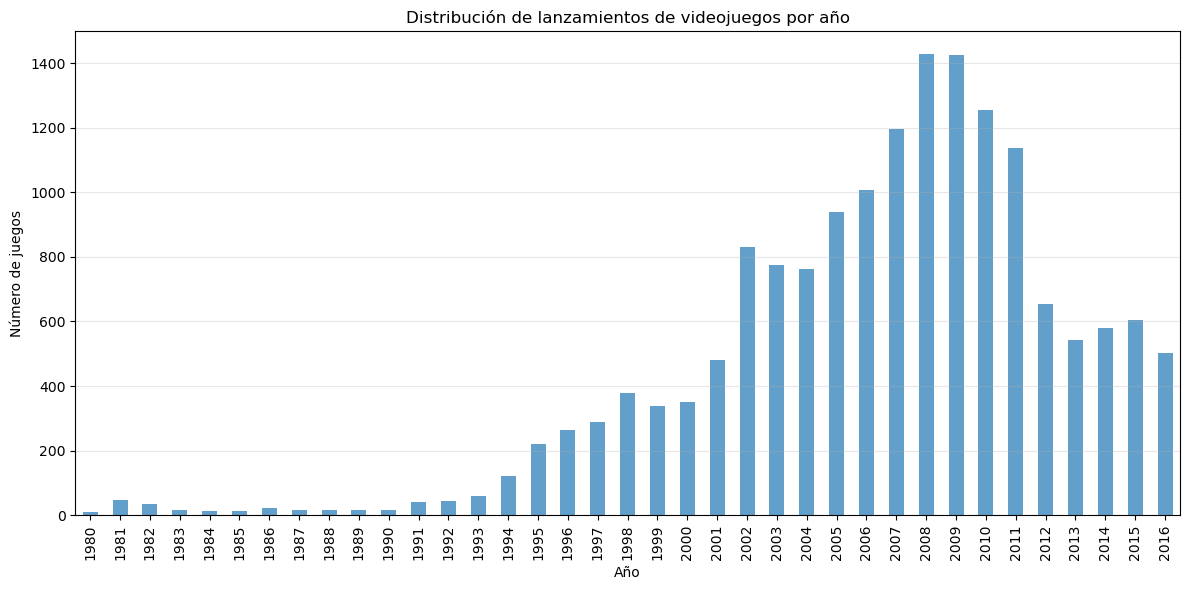

decade
1980s       205
1990s      1769
2000s      9193
2010s      5277
sin año     269
Name: count, dtype: int64
decade
1980s       1.2
1990s      10.6
2000s      55.0
2010s      31.6
sin año     1.6
Name: count, dtype: float64

Rango de años: 1980 - 2016
Total de años con datos: 37
Año con más lanzamientos: 2008 (1427 juegos)
Año con menos lanzamientos: 1980 (9 juegos)


In [60]:
# Análisis de juegos lanzados por año
games_per_year = df["year_of_release"].value_counts().sort_index()
print(games_per_year.head()) # Corroboramos que si se hayan ordenado según el año

# Llamé la librería matplotlib y genero el gráfico para analizar la distribución
plt.figure(figsize = (12, 6))
games_per_year.plot(kind = "bar", alpha = 0.7, 
                   title = "Distribución de lanzamientos de videojuegos por año",
                   xlabel = "Año",
                   ylabel = "Número de juegos",
                   )
plt.grid(axis = "y", alpha = 0.3)
plt.tight_layout()
plt.show()

# Teniendo en cuenta cuales son los años con mayores lanzamientos, ya tengo una idea pero para comprobar los dividiré por década
# Análisis por década
def get_decade(year):
    if pd.isna(year):
        return "sin año"
    return f"{int(year//10)*10}s"
df["decade"] = df["year_of_release"].apply(get_decade)
games_per_decade = df["decade"].value_counts().sort_index()
print(games_per_decade)

# Ahora que nos dicen estos valores si los convertimos a porcentaje
print((games_per_decade / len(df)*100).round(1))
print()

# Se me ocurrió determinar las estádisticas descriptivas y ver que características podemos determinar con todo esto.
print(f"Rango de años: {games_per_year.index.min()} - {games_per_year.index.max()}")
print(f"Total de años con datos: {len(games_per_year)}")
print(f"Año con más lanzamientos: {games_per_year.idxmax()} ({games_per_year.max()} juegos)")
print(f"Año con menos lanzamientos: {games_per_year.idxmin()} ({games_per_year.min()} juegos)")


### Conclusón de años de distribución 
Los años con mayor cantidad de juegos lanzados fueron 2008 - 2011
Los años con mayor actividad fueron del 2000 - 2015
uno de los patrones que se rompe es en 1980 y 1990. 
Los juegos en los años 200's son predominantes en la lista.

### - En este apartado se observarán como varían las ventas en una plataforma a otra. veremos cuales son las plataformas con mayores ventas totales y se observará la distribución basada en los datos de cada año.


platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64
platform         PS2  X360  PS3  Wii    DS   PS  GBA  PS4  PSP    PC
year_of_release                                                     
1980             0.0   0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0  0.00
1981             0.0   0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0  0.00
1982             0.0   0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0  0.00
1983             0.0   0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0  0.00
1984             0.0   0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0  0.00
1985             0.0   0.0  0.0  0.0  0.02  0.0  0.0  0.0  0.0  0.04
1986             0.0   0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0  0.00
1987             0.0   0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0  0.00
1988             0.0   0.0  0.0  0.0  0.00  0.0  0.0  0.0  0.0  0.03
1989             0.0   0.0  0.0  0.0  

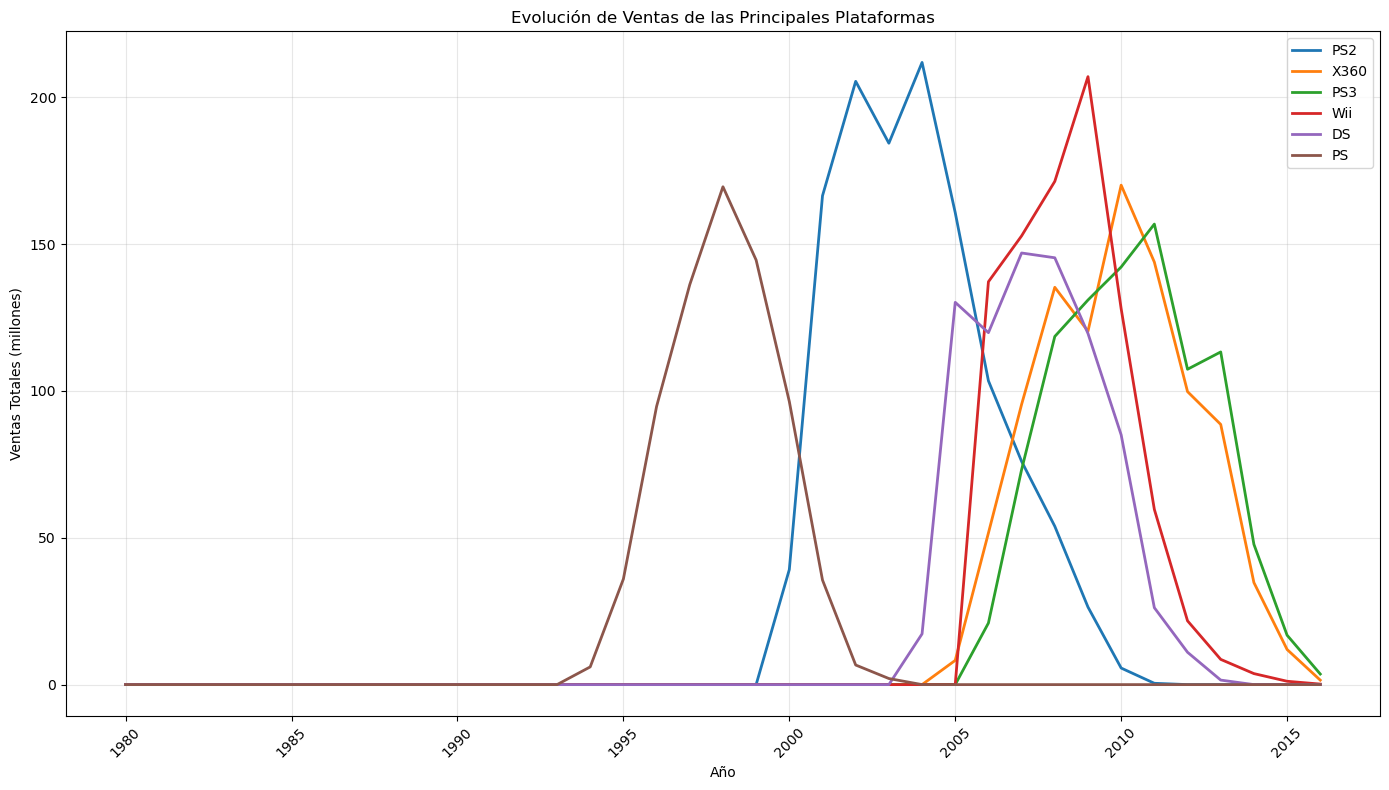

In [92]:
# plataformas con mayores ventas totales
df["total_sales"] = df["na_sales"] + df["eu_sales"] + df["jp_sales"] +df["other_sales"]
total_sales_by_platform = df.groupby("platform")[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum()
total_sales_by_platform["total_sales"] = total_sales_by_platform.sum(axis = 1)
top_platforms = total_sales_by_platform.nlargest(10, "total_sales")
print(top_platforms["total_sales"].round(2))
# Distribución anual por plataforma
top_platforms_list = top_platforms.index.tolist()

#Ventas anuales por plataforma
annual_sales = df.groupby(["year_of_release", "platform"])["total_sales"].sum().unstack(fill_value = 0)

# Filtrar solo por las plataformas top 
top_platforms_annual = annual_sales[top_platforms_list]

print(top_platforms_annual.head(10))

plt.figure(figsize=(14, 8))
for platform in top_platforms_list[:6]:  # Primeras 6 para claridad
    platform_data = top_platforms_annual[platform]
    plt.plot(platform_data.index, platform_data.values, label=platform, linewidth=2)
plt.title('Evolución de Ventas de las Principales Plataformas')
plt.xlabel('Año')
plt.ylabel('Ventas Totales (millones)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Conclusión 
Por lo tanto concluimos que las plataformas con mayores ventas fueron la PS2, XBox360, PS3, Wii, DS.
Por el comportamiento de la tabla determinamos que las ventas decrecieron de todas estas plataformas antes mencionadas.
La PS2 lidera las ventas ya que supera las 200 millones de ventas. Por segundo lugar esta la xBox360 y tiene comportamientos muy peculiares, ya que a pesar de ser de años diferentes, la Ps2 parecía dejar de ser una tendencia y volvío a serlo.

### - Ahora en este apartado determinaremos para que periodo debo tomar datos.

He decidido tomar datos del 2000 al 2016 debido a que hay los datos suficientes para trabajar co ellos, esto significa también que la industria de los videojuegos ya es considerada mas enserio como negocio.

In [97]:
# Primero un filtro de datos para el periodo 2000 - 2016
df_recent = df[(df["year_of_release"] >= 2000) & (df["year_of_release"] <= 2016)].copy()

# Verificamos cuantos datos tenemos respecto a la cantidad de datos y los años cubiertos
print(f"Juegos en el periodo 2000-2016: {len(df_recent)}")
print(f"Años cubiertos: {df_recent["year_of_release"].min()} - {df_recent["year_of_release"].max()}")

# Plataformas más populares recientemente 
recent_sales = df_recent.groupby("platform")["total_sales"].sum()
top_platforms_recent = recent_sales.nlargest(10)

print(top_platforms_recent.round(2))

Juegos en el periodo 2000-2016: 14470
Años cubiertos: 2000 - 2016
platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
XB       251.57
Name: total_sales, dtype: float64


Por lo tanto, analizando estos datos con la gráfica anterior, descartamos las plataformas que iban en declibe o estan descontinuadas por ejemplo la PS2, ya que si generó el mayor pico de ventas de videojuegos, pero estuvo en declibe y ahorita ya no aporta valor, pero aquí aparecen dos plataformas clave que es la PS4 y la 3DS ya que son las únicas plataformas actuales(2016), tieenn soporte continuo por ser nuevas y tiene una base de usuarios activa y creciente. Esto mos dice que invertir en la PS4 y 3DS es lo mejor porque son las únicas que tienen futuro.

### Ahora crearemos un diagrama de caja para las ventas globales de todos los juegos desglosados por plataforma.

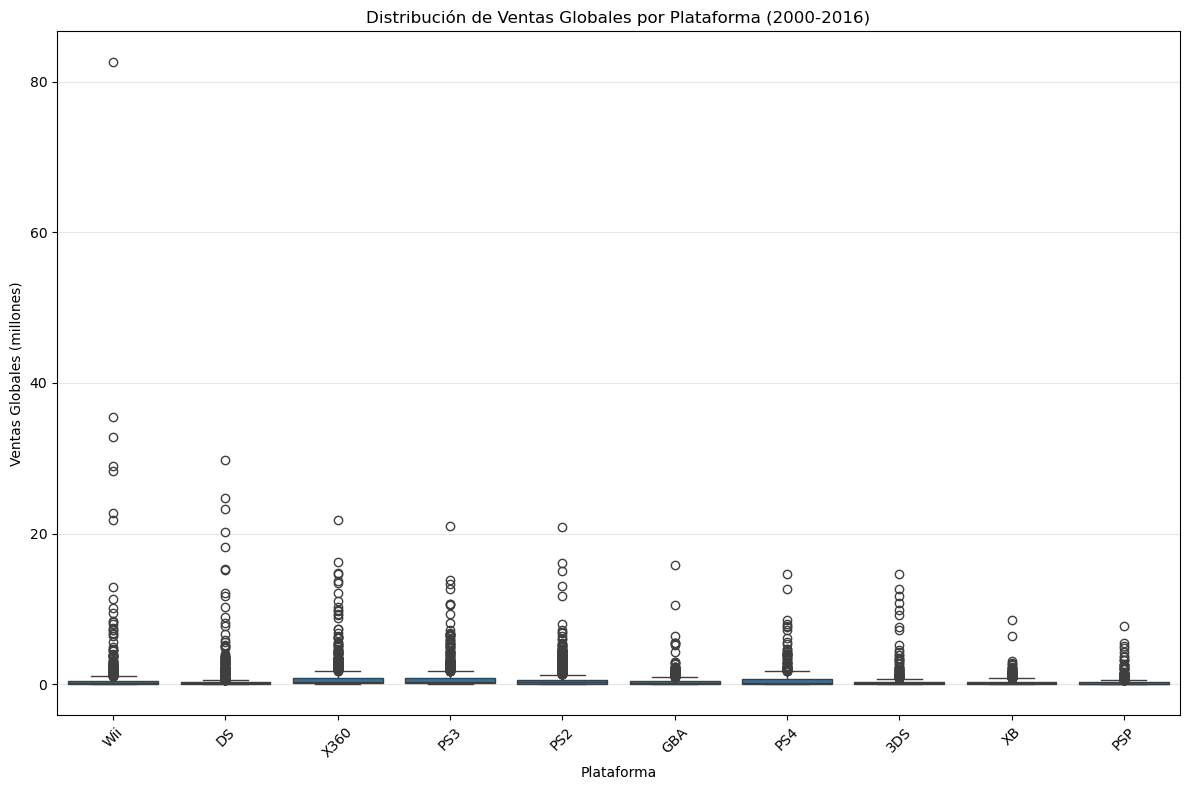

Estadística de ventas por plataforma
          mean   50%   std    max
platform                         
3DS       0.50  0.12  1.44  14.60
DS        0.38  0.11  1.44  29.80
GBA       0.39  0.16  0.90  15.84
PS2       0.58  0.23  1.14  20.81
PS3       0.71  0.28  1.40  21.05
PS4       0.80  0.20  1.61  14.63
PSP       0.24  0.09  0.52   7.68
Wii       0.69  0.19  3.17  82.54
X360      0.78  0.28  1.63  21.82
XB        0.31  0.15  0.54   8.48


In [102]:
top_platforms = ["PS2", "X360", "PS3", "Wii", "DS", "PS4", "GBA", "PSP", "3DS", "XB"]
df_top_platforms = df_recent[df_recent["platform"].isin(top_platforms)]

# Creación del diagrama de caja
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_platforms, x='platform', y='total_sales')
plt.title('Distribución de Ventas Globales por Plataforma (2000-2016)')
plt.xlabel('Plataforma')
plt.ylabel('Ventas Globales (millones)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calcular estadísticas descriptivas
sales_stats = df_top_platforms.groupby('platform')['total_sales'].describe()
print("Estadística de ventas por plataforma")
print(sales_stats[['mean', '50%', 'std', 'max']].round(2))

### Conclusiones del gráfico y resultados 

- Las diferencias de ventas son muy dignificativas. tiene un rango amplio de ventas promedio, van desde 0.24 hasta 0.8 millones
- La plataforma más exitosa es la PS4 vende 3.3 veces más que la menos exitosa que es la PSP.
- Entre generaciones de consolas hay una diferencia muy marcada por ejemplo PS2 su media es de 0.58, PS3 0.71 y PS4 0.80 Millones 
### Plataformas con mejor desempeño 
1. PS4
2. X360
3. PS3

### Plataformas con peor desempeño 
1. PSP
2. XB
3. DS
4. GBA

### Hallazgos importantes:
las consolas de sobremesa dominan por ejemplo PS4, X360 y PS3 que son los que tienen promedios mas altos
las consolas portatiles son las que tienen promedios mas bajos por ejemplo PSP y DS. La 3DS podría ser la excepción pero sigue estando abajo el promedio respecto a las demás.

- La mediana escrita por el 50% revela que todas son menor o igual a 0.28 millones. esto significa que el 50% de los juegos venden menos de 280,000 copias.

### Aquí analizaremos las reseñas de los usuarios y profesionales y como afectan las ventas de una plataforma popular, en este caso escogí la PS4 

Juegos de PS4 con reseñas completas: 249


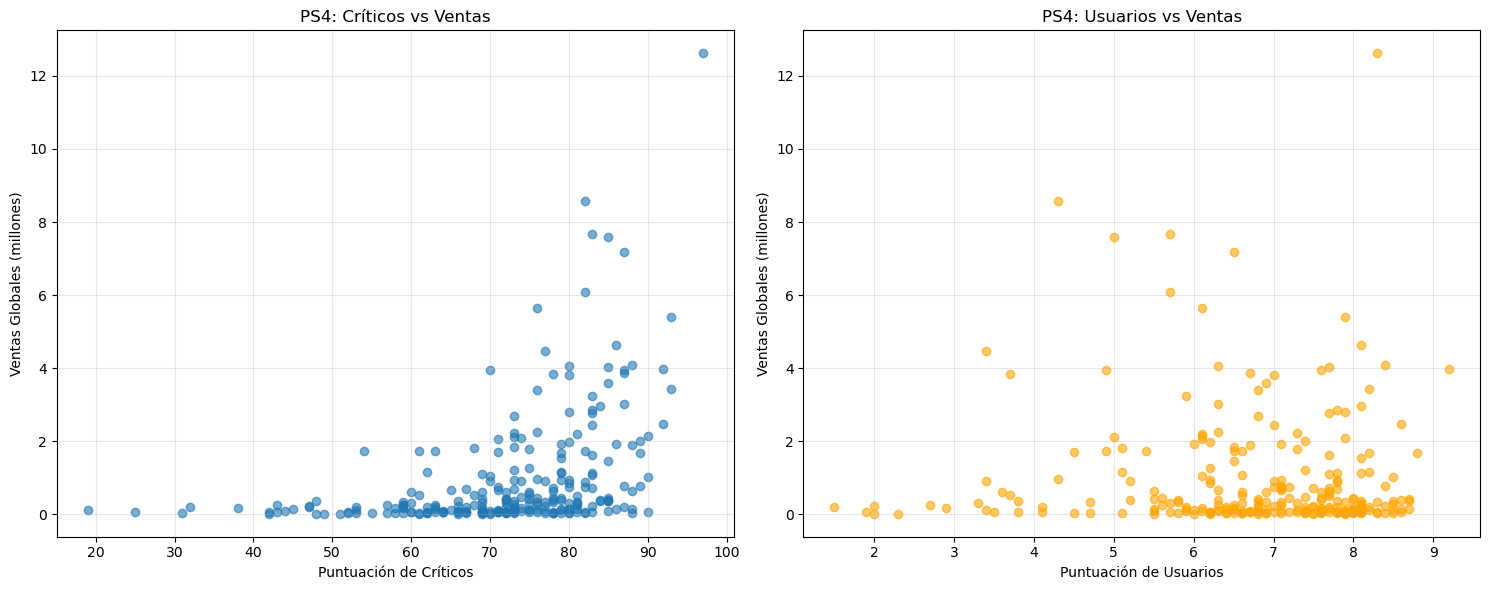

Correlaciones
Críticos vs Ventas: 0.406
Usuarios vs Ventas: -0.034


In [107]:
# Filtrar datos de PS4 con reseñas disponibles
ps4_data = df_recent[
    (df_recent['platform'] == 'PS4') & 
    (df_recent['critic_score'].notna()) & 
    (df_recent['user_score'].notna())
].copy()

# Determinamos con cuantas reseñas contamos de critic y user. 
print(f"Juegos de PS4 con reseñas completas: {len(ps4_data)}")

#Creacion de gráfico 
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1, 2, 1) 
ax1.scatter(ps4_data['critic_score'], ps4_data['total_sales'], alpha=0.6)
ax1.set_xlabel('Puntuación de Críticos')
ax1.set_ylabel('Ventas Globales (millones)')
ax1.set_title('PS4: Críticos vs Ventas')
ax1.grid(alpha=0.3)
ax2 = fig.add_subplot(1, 2, 2) 
ax2.scatter(ps4_data['user_score'], ps4_data['total_sales'], alpha=0.6, color='orange')
ax2.set_xlabel('Puntuación de Usuarios')
ax2.set_ylabel('Ventas Globales (millones)')
ax2.set_title('PS4: Usuarios vs Ventas')
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculamos las correlaciones
corr_critic = ps4_data['critic_score'].corr(ps4_data['total_sales'])
corr_user = ps4_data['user_score'].corr(ps4_data['total_sales'])

print("Correlaciones")
print(f"Críticos vs Ventas: {corr_critic:.3f}")
print(f"Usuarios vs Ventas: {corr_user:.3f}")

In [111]:
print("Análisis mas a detalle de PS4")
print(f"Rango críticos: {ps4_data['critic_score'].min():.0f}-{ps4_data['critic_score'].max():.0f}")
print(f"Rango usuarios: {ps4_data['user_score'].min():.1f}-{ps4_data['user_score'].max():.1f}")
print(f"Rango ventas: {ps4_data['total_sales'].min():.2f}-{ps4_data['total_sales'].max():.2f}M")
print()
print("Distribución de user_score:")
print(ps4_data['user_score'].describe())

# Detalles para buscar los valores de user_score 
print(f"\nEjemplos problemáticos:")
problem_games = ps4_data[ps4_data['user_score'] < 3]  # Juegos con muy baja puntuación
if len(problem_games) > 0:
    print(problem_games[['name', 'user_score', 'total_sales']].head())
    

Análisis mas a detalle de PS4
Rango críticos: 19-97
Rango usuarios: 1.5-9.2
Rango ventas: 0.01-12.62M

Distribución de user_score:
count    249.000000
mean       6.749799
std        1.455693
min        1.500000
25%        6.100000
50%        7.000000
75%        7.800000
max        9.200000
Name: user_score, dtype: float64

Ejemplos problemáticos:
                           name  user_score  total_sales
6911                NBA Live 14         2.7         0.24
7296      Angry Birds Star Wars         2.0         0.22
7479   Tony Hawk's Pro Skater 5         1.5         0.20
8636                Putty Squad         2.9         0.16
12756      Rugby World Cup 2015         1.9         0.06


### Conclusiones respecto a PS4
- Críticos vs ventas
Nuestra correlación es positiva, debido a que 0.406 es una buena correlación. Las buenas reseñas de críticos si se relacionan con mejores ventas. Los medios especializados influyen en las decisiones de compra.
- Usarios vs ventas
Correlación practicamente cero, por lo tanto no hay relación entre puntuación de usuarios y ventas.

### Conclusiones generales
- Por lo tanto, los juegos muy anticipados venden mucho al lanzamiento.
- Los usuarios los califican después, cuando ya se vendieron.
- Discrepancia entre expectativas y experiencia real.

### Conclusiones para el 2017
- Invertir en relaciones con criterios, ya que su opinión si afecta en las ventas
- las reseñas de usuarios No predicen ventas, no basar las decisiones solo en esto
- El Marketing es la clave para las ventas inciales ya que es crucial


### En este apartado, tomaremos en cuenta el mismo juego, pero comparado ahora con diferentes plataformas

Juegos en múltiples plataformas: 2548


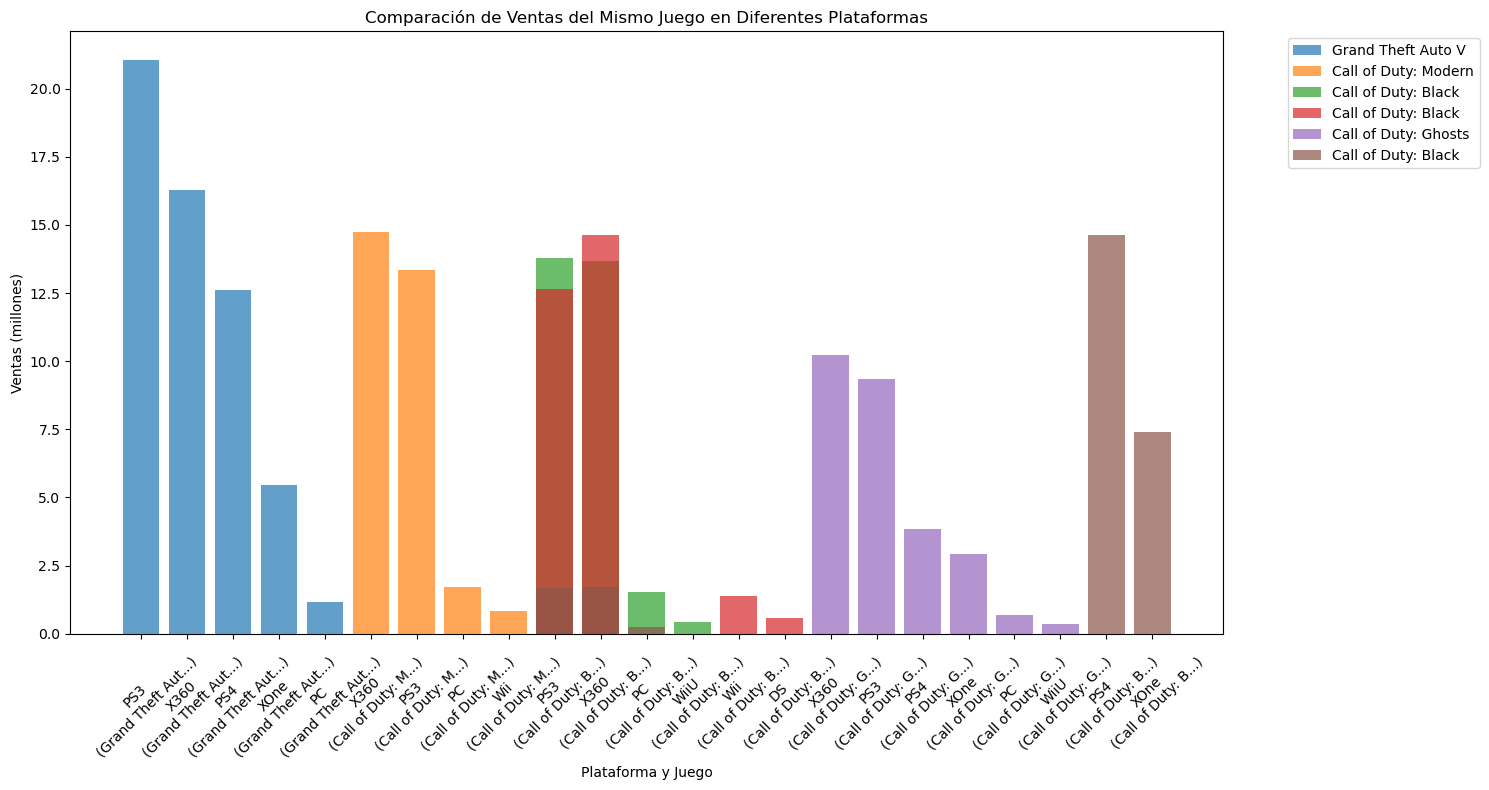


=== ANÁLISIS CUANTITATIVO ===
Ratio promedio de diferencia: infx
Plataforma más frecuentemente ganadora: PS2
Plataforma más frecuentemente perdedora: PC
Ejemplos
Mayores diferencias:
SCORE International Baja 1000:...: X360(0.1M) vs PS2(0.0M) - infx
Grand Theft Auto III...: PS2(13.1M) vs PC(0.0M) - 1310.0x
Gears of War...: X360(6.1M) vs PC(0.0M) - 609.0x
Winning Eleven: Pro Evolution ...: PS2(4.4M) vs PC(0.0M) - 440.0x
Grand Theft Auto: Vice City...: PS2(16.2M) vs PC(0.0M) - 403.8x


In [117]:
# Identificar juegos que están en múltiples plataformas
multi_platform_games = df_recent.groupby('name')['platform'].nunique()
multi_platform_games = multi_platform_games[multi_platform_games > 1].index
print(f"Juegos en múltiples plataformas: {len(multi_platform_games)}")

# Filtrar solo estos juegos
cross_platform_df = df_recent[df_recent['name'].isin(multi_platform_games)]

# Tomar algunos juegos populares para análisis
popular_cross_games = cross_platform_df.groupby('name')['total_sales'].sum().nlargest(10).index
# Crear comparación visual
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
# Para cada juego popular, mostrar ventas por plataforma
for i, game in enumerate(popular_cross_games[:6]):  # Primeros 6 para claridad
    game_data = cross_platform_df[cross_platform_df['name'] == game]
    platforms = game_data['platform'].tolist()
    sales = game_data['total_sales'].tolist()
    
    ax.bar([p + f'\n({game[:15]}...)' for p in platforms], sales, alpha=0.7, label=game[:20])

ax.set_xlabel('Plataforma y Juego')
ax.set_ylabel('Ventas (millones)')
ax.set_title('Comparación de Ventas del Mismo Juego en Diferentes Plataformas')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Análisis cuantitativo
print("\n=== ANÁLISIS CUANTITATIVO ===")

# Para cada juego multi-plataforma, calcular diferencia entre plataformas
platform_performance = []

for game in multi_platform_games:
    game_data = cross_platform_df[cross_platform_df['name'] == game]
    if len(game_data) > 1:
        max_sales = game_data['total_sales'].max()
        min_sales = game_data['total_sales'].min()
        ratio = max_sales / min_sales if min_sales > 0 else float('inf')
        
        best_platform = game_data.loc[game_data['total_sales'].idxmax(), 'platform']
        worst_platform = game_data.loc[game_data['total_sales'].idxmin(), 'platform']
        
        platform_performance.append({
            'game': game,
            'max_sales': max_sales,
            'min_sales': min_sales,
            'ratio': ratio,
            'best_platform': best_platform,
            'worst_platform': worst_platform
        })

# Convertir a DataFrame
performance_df = pd.DataFrame(platform_performance)

print(f"Ratio promedio de diferencia: {performance_df['ratio'].mean():.1f}x")
print(f"Plataforma más frecuentemente ganadora: {performance_df['best_platform'].value_counts().idxmax()}")
print(f"Plataforma más frecuentemente perdedora: {performance_df['worst_platform'].value_counts().idxmax()}")

# Mostrar ejemplos extremos
print("Ejemplos")
print("Mayores diferencias:")
extreme_differences = performance_df.nlargest(5, 'ratio')
for _, row in extreme_differences.iterrows():
    print(f"{row['game'][:30]}...: {row['best_platform']}({row['max_sales']:.1f}M) vs {row['worst_platform']}({row['min_sales']:.1f}M) - {row['ratio']:.1f}x")

### Conclusión
- El mismo juego puede vender dos veces más, hasta 5 veces más en una plataforma vs otra.
- PS4 y X360 probablemente lideren en versiones multiplataforma.
- Las consolas no portátiles siguen vendiendo mas que las portátiles.



### En este apartado, veremos la distribucón general de los juegos por género. Para decir cuales son los generos más rentables y si se puede generalizar acerca de los géneros con ventas altas y bajas.

Análisis de géneros del 2000-2016
              num_juegos  ventas_totales  ventas_promedio  ventas_mediana  \
genre                                                                       
Action              3079         1526.16             0.50            0.18   
Sports              1979         1130.92             0.57            0.21   
Shooter             1129          912.70             0.81            0.24   
Role-Playing        1300          731.22             0.56            0.16   
Misc                1597          718.35             0.45            0.15   
Racing              1035          561.06             0.54            0.17   
Platform             720          494.42             0.69            0.21   
Simulation           768          335.41             0.44            0.14   
Fighting             640          311.90             0.49            0.19   
Adventure           1194          183.74             0.15            0.05   
Puzzle               479          138.20  

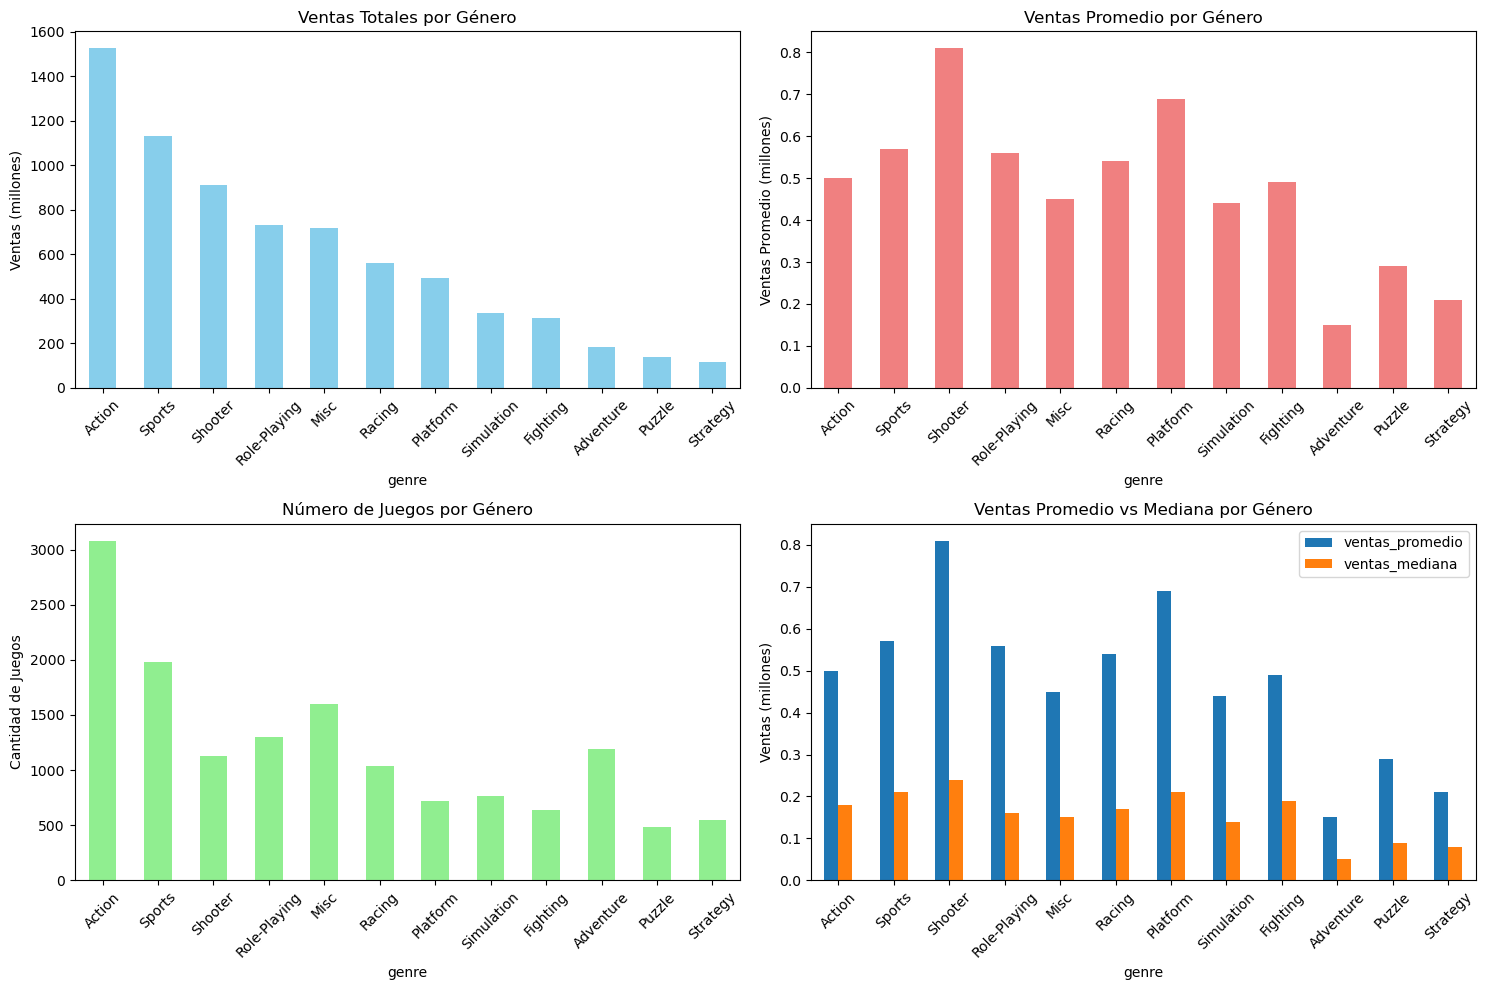

Clasificación de rentabilidad
Géneros de alta rentabilidad:
              ventas_promedio  ventas_mediana  eficiencia
genre                                                    
Shooter                  0.81            0.24        0.72
Platform                 0.69            0.21        0.96
Sports                   0.57            0.21        0.29
Role-Playing             0.56            0.16        0.43
Racing                   0.54            0.17        0.52
Action                   0.50            0.18        0.16
Géneros de baja rentabilidad:
            ventas_promedio  ventas_mediana  eficiencia
genre                                                  
Fighting               0.49            0.19        0.77
Misc                   0.45            0.15        0.28
Simulation             0.44            0.14        0.57
Puzzle                 0.29            0.09        0.61
Strategy               0.21            0.08        0.38
Adventure              0.15            0.05        0.1

In [120]:
genre_analysis = df_recent.groupby('genre').agg({
    'total_sales': ['count', 'sum', 'mean', 'median'],
    'critic_score': 'mean',
    'user_score': 'mean'
}).round(2)

# Renombrar columnas para claridad
genre_analysis.columns = ['num_juegos', 'ventas_totales', 'ventas_promedio', 'ventas_mediana', 
                        'criticos_promedio', 'usuarios_promedio']

# Ordenar por ventas totales
genre_analysis = genre_analysis.sort_values('ventas_totales', ascending=False)

print("Análisis de géneros del 2000-2016")
print(genre_analysis)

# Gráfico de ventas por género
fig = plt.figure(figsize=(15, 10))

# Gráfico 1: Ventas totales por género
ax1 = fig.add_subplot(2, 2, 1)
genre_analysis['ventas_totales'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Ventas Totales por Género')
ax1.set_ylabel('Ventas (millones)')
plt.xticks(rotation=45)

# Gráfico 2: Ventas promedio por género
ax2 = fig.add_subplot(2, 2, 2)
genre_analysis['ventas_promedio'].plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Ventas Promedio por Género')
ax2.set_ylabel('Ventas Promedio (millones)')
plt.xticks(rotation=45)

# Gráfico 3: Número de juegos por género
ax3 = fig.add_subplot(2, 2, 3)
genre_analysis['num_juegos'].plot(kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('Número de Juegos por Género')
ax3.set_ylabel('Cantidad de Juegos')
plt.xticks(rotation=45)

# Gráfico 4: Ventas mediana vs promedio
ax4 = fig.add_subplot(2, 2, 4)
genre_analysis[['ventas_promedio', 'ventas_mediana']].plot(kind='bar', ax=ax4)
ax4.set_title('Ventas Promedio vs Mediana por Género')
ax4.set_ylabel('Ventas (millones)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Análisis de rentabilidad
print("Clasificación de rentabilidad")

# Calcular eficiencia (ventas promedio / cantidad de juegos)
genre_analysis['eficiencia'] = (genre_analysis['ventas_promedio'] / genre_analysis['num_juegos'] * 1000).round(2)

# Clasificar géneros
high_sales = genre_analysis[genre_analysis['ventas_promedio'] > genre_analysis['ventas_promedio'].median()]
low_sales = genre_analysis[genre_analysis['ventas_promedio'] <= genre_analysis['ventas_promedio'].median()]

print("Géneros de alta rentabilidad:")
print(high_sales[['ventas_promedio', 'ventas_mediana', 'eficiencia']].sort_values('ventas_promedio', ascending=False))

print("Géneros de baja rentabilidad:")
print(low_sales[['ventas_promedio', 'ventas_mediana', 'eficiencia']].sort_values('ventas_promedio', ascending=False))

### Conclusiones de rentabilidad según el género
Los géneros más rentables fueron:
1. Shooter en primer lugar, con un alto promedio y con grandes franquicias como Call of Duty y Halo
2. Action, con un mercado amplio
3. Sports con ventas anuales consistentes, con juegos como FIFA y Madden.
Pero con estos datos tenemos también que la alta rentabilidad es un riesgo alto, debido a que son presupuestos altos y hay más competencia entre ellos, por lo tanto se necesita una mejor campaña de marketing y dependen de gráficos de última generación.
los juegos con baja rentabilidad como lo son rompecabezas, acción, etc. necesitas menor presupuesto, son mercados más estables y menos dependientes a los gráficos.

Como conclusión general, si hay presupuesto puedes invertir en juegos de shooter, si cuentas con un estudio pequeño, un juego de rompecabezas es algo considerable y un juego de deportes para ventas año con año.

# Paso 4.

### En este apartado estudiaremos cada región, primero veremos sus principales consolas.

Top 5 plataformas por región
Norteamerica (NA):
          na_sales  na_pct
platform                  
X360        595.74    16.9
PS2         572.92    16.2
Wii         486.87    13.8
PS3         390.13    11.1
DS          380.31    10.8

Cuota total del top 5: 68.8%
Europa (EU):
          eu_sales  eu_pct
platform                  
PS2         332.63    15.9
PS3         327.21    15.7
X360        268.32    12.9
Wii         258.32    12.4
DS          188.41     9.0

Cuota total del top 5: 65.9%
Japón (JP):
          jp_sales  jp_pct
platform                  
DS          175.00    21.5
PS2         137.54    16.9
3DS         100.62    12.3
PS3          79.41     9.7
PSP          75.88     9.3

Cuota total del top 5: 69.7%


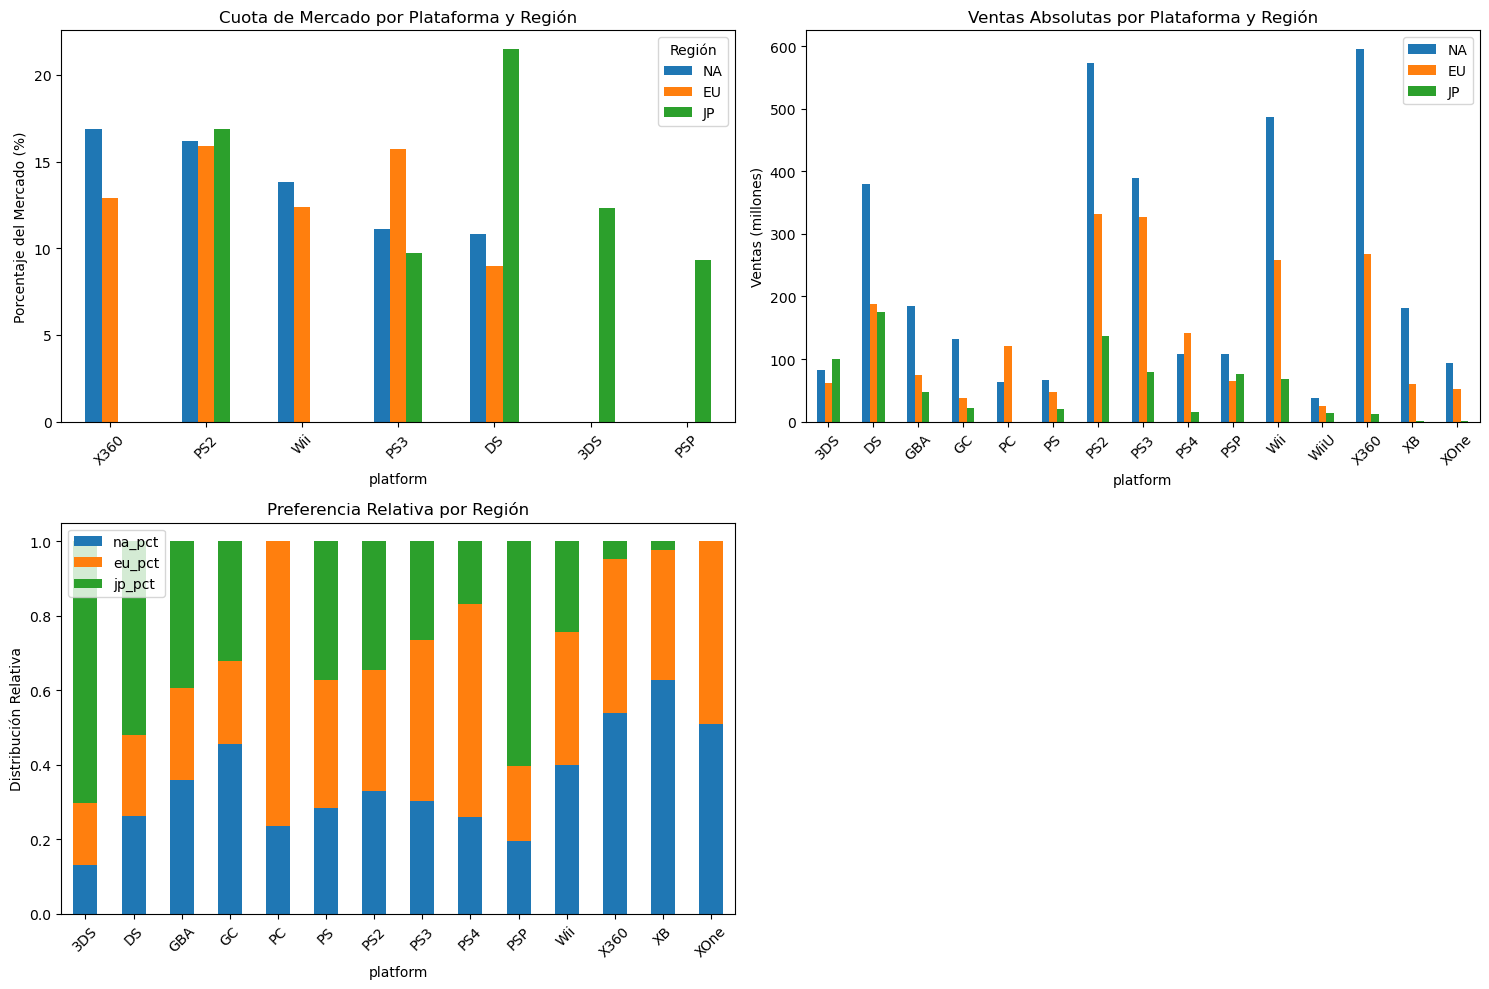

Análisis de diferencias regionales

Plataformas más populares en NA/EU vs JP:
          na_pct  jp_pct  na_vs_jp_ratio
platform                                
PC           1.8     0.0             inf
XOne         2.6     0.0             inf
XB           5.2     0.2            26.0
X360        16.9     1.5            11.3

Plataformas más populares en JP vs NA/EU:
          jp_pct  na_pct  eu_pct
platform                        
DS          21.5    10.8     9.0
PS2         16.9    16.2    15.9
3DS         12.3     2.3     2.9
PSP          9.3     3.0     3.1
GBA          5.7     5.2     3.6


In [124]:
# Calcular ventas por región y plataforma
region_sales = df_recent.groupby('platform').agg({
    'na_sales': 'sum',
    'eu_sales': 'sum', 
    'jp_sales': 'sum',
    'other_sales': 'sum'
}).round(2)

# Calcular porcentajes por región
region_sales['na_pct'] = (region_sales['na_sales'] / region_sales['na_sales'].sum() * 100).round(1)
region_sales['eu_pct'] = (region_sales['eu_sales'] / region_sales['eu_sales'].sum() * 100).round(1)
region_sales['jp_pct'] = (region_sales['jp_sales'] / region_sales['jp_sales'].sum() * 100).round(1)

# Top 5 plataformas por región
top_na = region_sales.nlargest(5, 'na_pct')[['na_sales', 'na_pct']]
top_eu = region_sales.nlargest(5, 'eu_pct')[['eu_sales', 'eu_pct']]
top_jp = region_sales.nlargest(5, 'jp_pct')[['jp_sales', 'jp_pct']]

print("Top 5 plataformas por región")
print("Norteamerica (NA):")
print(top_na)
print(f"\nCuota total del top 5: {top_na['na_pct'].sum():.1f}%")

print("Europa (EU):")
print(top_eu)
print(f"\nCuota total del top 5: {top_eu['eu_pct'].sum():.1f}%")

print("Japón (JP):")
print(top_jp)
print(f"\nCuota total del top 5: {top_jp['jp_pct'].sum():.1f}%")
# Crear visualización comparativa
fig = plt.figure(figsize=(15, 10))

# Gráfico 1: Comparación de cuotas de mercado
ax1 = fig.add_subplot(2, 2, 1)
top_platforms_combined = pd.concat({
    'NA': top_na['na_pct'],
    'EU': top_eu['eu_pct'], 
    'JP': top_jp['jp_pct']
}, axis=1).fillna(0)

top_platforms_combined.plot(kind='bar', ax=ax1)
ax1.set_title('Cuota de Mercado por Plataforma y Región')
ax1.set_ylabel('Porcentaje del Mercado (%)')
ax1.legend(title='Región')
plt.xticks(rotation=45)

# Gráfico 2: Ventas absolutas por región
ax2 = fig.add_subplot(2, 2, 2)
region_totals = pd.DataFrame({
    'NA': region_sales['na_sales'],
    'EU': region_sales['eu_sales'],
    'JP': region_sales['jp_sales']
})
region_totals = region_totals[region_totals.sum(axis=1) > 50]  # Filtrar plataformas relevantes
region_totals.plot(kind='bar', ax=ax2)
ax2.set_title('Ventas Absolutas por Plataforma y Región')
ax2.set_ylabel('Ventas (millones)')
plt.xticks(rotation=45)

# Gráfico 3: Preferencias regionales (normalizado)
ax3 = fig.add_subplot(2, 2, 3)
regional_preference = region_sales[['na_pct', 'eu_pct', 'jp_pct']]
regional_preference = regional_preference[regional_preference.sum(axis=1) > 5]  # Plataformas significativas

# Normalizar por fila para ver preferencias relativas
preference_normalized = regional_preference.div(regional_preference.sum(axis=1), axis=0)
preference_normalized.plot(kind='bar', ax=ax3, stacked=True)
ax3.set_title('Preferencia Relativa por Región')
ax3.set_ylabel('Distribución Relativa')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Análisis de diferencias regionales
print("Análisis de diferencias regionales")

# Plataformas con mayor diferencia entre regiones
region_sales['na_vs_jp_ratio'] = (region_sales['na_pct'] / region_sales['jp_pct']).round(1)
region_sales['eu_vs_jp_ratio'] = (region_sales['eu_pct'] / region_sales['jp_pct']).round(1)

print("\nPlataformas más populares en NA/EU vs JP:")
western_bias = region_sales[region_sales['na_vs_jp_ratio'] > 3].nlargest(5, 'na_vs_jp_ratio')
print(western_bias[['na_pct', 'jp_pct', 'na_vs_jp_ratio']])

print("\nPlataformas más populares en JP vs NA/EU:")
japan_bias = region_sales[region_sales['jp_pct'] > region_sales['na_pct']].nlargest(5, 'jp_pct')
print(japan_bias[['jp_pct', 'na_pct', 'eu_pct']])

### Las principales consolas por región ya están más claras en la gráfica, por lo tanto, las explicaremos en este apartado:
- Norteamérica:
  1. X360
  2. PS4/PS3
  3. Wii
- Europa:
  1. PS4/PS3/PS2
  2. X360
  3. Wii
- Japón:
  1. 3DS/DS
  2. PS4/PS3/PSP
  3. Wii

Como conclusión, las consolas de Sony son fuerte en las 3 regiones, Microsoft domina en Norteamérica, pero en Japón es débil y nintendo aparece de una forma más discreta, pero tiene el dominio en Japón.


### En este apartado analizaremos los 5 géneros principales de cada región

In [129]:
# Calcular ventas por género y región
genre_region = df_recent.groupby('genre').agg({
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'total_sales': 'sum'
}).round(2)

# Calcular porcentajes por región
genre_region['na_pct'] = (genre_region['na_sales'] / genre_region['na_sales'].sum() * 100).round(1)
genre_region['eu_pct'] = (genre_region['eu_sales'] / genre_region['eu_sales'].sum() * 100).round(1)
genre_region['jp_pct'] = (genre_region['jp_sales'] / genre_region['jp_sales'].sum() * 100).round(1)

# Top 5 géneros por región
top_na_genres = genre_region.nlargest(5, 'na_pct')[['na_sales', 'na_pct']]
top_eu_genres = genre_region.nlargest(5, 'eu_pct')[['eu_sales', 'eu_pct']]
top_jp_genres = genre_region.nlargest(5, 'jp_pct')[['jp_sales', 'jp_pct']]

print("Top 5 géneros por región")
print("Norteamérica:")
print(top_na_genres)
print(f"Cuota mercado top 5: {top_na_genres['na_pct'].sum():.1f}%")

print("Europa:")
print(top_eu_genres)
print(f"Cuota mercado top 5: {top_eu_genres['eu_pct'].sum():.1f}%")

print("Japón:")
print(top_jp_genres)
print(f"Cuota mercado top 5: {top_jp_genres['jp_pct'].sum():.1f}%")

print("Análisis de diferencias regionales")
# Géneros con mayor diferencia entre regiones
genre_region['na_vs_jp_ratio'] = (genre_region['na_pct'] / genre_region['jp_pct']).round(1)
genre_region['eu_vs_jp_ratio'] = (genre_region['eu_pct'] / genre_region['jp_pct']).round(1)

print("\nGéneros más populares en NA/EU vs JP:")
western_genres = genre_region[genre_region['na_vs_jp_ratio'] > 2].nlargest(5, 'na_vs_jp_ratio')
print(western_genres[['na_pct', 'jp_pct', 'na_vs_jp_ratio']])

print("\nGéneros más populares en JP vs NA/EU:")
japan_genres = genre_region[genre_region['jp_pct'] > genre_region['na_pct']].nlargest(5, 'jp_pct')
print(japan_genres[['jp_pct', 'na_pct', 'eu_pct']])

Top 5 géneros por región
Norteamérica:
              na_sales  na_pct
genre                         
Action          752.27    21.3
Sports          589.39    16.7
Shooter         495.23    14.0
Misc            365.27    10.3
Role-Playing    282.30     8.0
Cuota mercado top 5: 70.3%
Europa:
         eu_sales  eu_pct
genre                    
Action     466.58    22.4
Sports     339.58    16.3
Shooter    294.02    14.1
Misc       196.71     9.4
Racing     192.02     9.2
Cuota mercado top 5: 71.4%
Japón:
              jp_sales  jp_pct
genre                         
Role-Playing    241.71    29.6
Action          132.23    16.2
Misc             85.43    10.5
Sports           75.88     9.3
Platform         55.27     6.8
Cuota mercado top 5: 72.4%
Análisis de diferencias regionales

Géneros más populares en NA/EU vs JP:
         na_pct  jp_pct  na_vs_jp_ratio
genre                                  
Shooter    14.0     2.9             4.8
Racing      7.7     3.4             2.3

Géneros más po

### Conclusiones de top 5 generos por región
las diferencias principales están en norteamérica y Europa con Japón, ya que los juegos de shooter llegan a ser del 14% en norteamérica y en japón el porcentaje es demasiado bajo, los role play por el contrario suelen ser mucho más populares en Japón, ya que tiene casi un 30% de audiencia, mientras que en Norteamérica solamente es del 8%. Algo que no esperaba es que los juegos de deportes llegan a ser similares en Europa y Norteamérica, pero en japón es menor su porcentaje de audicnecia, pero participando en sus top 5. Lo que nos hace pensar que la audiencia de deportes suele ser más estable en todas las regiones. Por lo que la localización de lanzamiento de cierto producto es escencial para el éxito global, pero teniendo géneros universales como lo es acción y deportes.

### En este apartado analizaremos si las calificaciones de ESRB afectan a las ventas en cada región

In [132]:
# Filtrar datos con rating ESRB disponible
df_esrb = df_recent[df_recent['rating'].isin(['E', 'E10+', 'T', 'M'])].copy()

# Calcular ventas por rating y región
rating_analysis = df_esrb.groupby('rating').agg({
    'na_sales': ['sum', 'mean', 'count'],
    'eu_sales': ['sum', 'mean', 'count'],
    'jp_sales': ['sum', 'mean', 'count'],
    'total_sales': ['sum', 'mean', 'count']
}).round(3)

# Aplanar columnas multi-index y ver los nombres reales
rating_analysis.columns = ['_'.join(col).strip() for col in rating_analysis.columns.values]
print("Nombres de columnas disponibles:")
print(rating_analysis.columns.tolist())

# Reorganizar para mejor visualización
na_data = rating_analysis[[col for col in rating_analysis.columns if 'na_' in col]]
eu_data = rating_analysis[[col for col in rating_analysis.columns if 'eu_' in col]]
jp_data = rating_analysis[[col for col in rating_analysis.columns if 'jp_' in col]]

print("Clasificación de ESRB por región")

print("Norteamérica:")
print(na_data)
# CORRECCIÓN: Usar el nombre correcto de la columna
print(f"\nDistribución NA: E({na_data['na_sales_sum'].get('E', 0):.0f}M) | E10+({na_data['na_sales_sum'].get('E10+', 0):.0f}M) | T({na_data['na_sales_sum'].get('T', 0):.0f}M) | M({na_data['na_sales_sum'].get('M', 0):.0f}M)")

print("Europa:")
print(eu_data)
print(f"\nDistribución EU: E({eu_data['eu_sales_sum'].get('E', 0):.0f}M) | E10+({eu_data['eu_sales_sum'].get('E10+', 0):.0f}M) | T({eu_data['eu_sales_sum'].get('T', 0):.0f}M) | M({eu_data['eu_sales_sum'].get('M', 0):.0f}M)")

print("Japón:")
print(jp_data)
print(f"\nDistribución JP: E({jp_data['jp_sales_sum'].get('E', 0):.0f}M) | E10+({jp_data['jp_sales_sum'].get('E10+', 0):.0f}M) | T({jp_data['jp_sales_sum'].get('T', 0):.0f}M) | M({jp_data['jp_sales_sum'].get('M', 0):.0f}M)")

Nombres de columnas disponibles:
['na_sales_sum', 'na_sales_mean', 'na_sales_count', 'eu_sales_sum', 'eu_sales_mean', 'eu_sales_count', 'jp_sales_sum', 'jp_sales_mean', 'jp_sales_count', 'total_sales_sum', 'total_sales_mean', 'total_sales_count']
Clasificación de ESRB por región
Norteamérica:
        na_sales_sum  na_sales_mean  na_sales_count
rating                                             
E            1249.26          0.322            3881
E10+          345.50          0.248            1392
M             727.80          0.479            1521
T             709.86          0.248            2859

Distribución NA: E(1249M) | E10+(346M) | T(710M) | M(728M)
Europa:
        eu_sales_sum  eu_sales_mean  eu_sales_count
rating                                             
E             690.61          0.178            3881
E10+          183.33          0.132            1392
M             472.40          0.311            1521
T             392.71          0.137            2859

Distribución 

### Según los resultados respecto a la clasificación ESRB estas son mis conclusiones

Europa y Norteamérica suelen consumir contenido maduro, y para todas las edades, ya que tienen congruencia al tener en sus juegos más vendidos tipos de juegos shooters y de acción. Por otra parte, en Japón por su cultura familiar y de ánime se suelen consumir más los juegos para todas las edades y para adolescentes, también aporta congruencia con los análisis anteriores, al ser también juegos portátiles los más populares. SI se gustaría invertir para un futuro, en Europa y Norteamérica podrían ser buenas opciones seguir con los patrones anteriores.

### Paso 5. 
Para este paso, aplicaremos las técnicas aprendidas de probabilidad y estadística, ya que se piden las hipótesis y promedios.

### Se piden comprobar que las calificaciones promedio de los usuarios para las plataformas XBox One y PC 

Por lo tanto usaremos su hipótesis nula si la calificación de los usuarios son iguales. Esto asume que no hay diferencia. La Hipótesis alternativa será lo contrario y con prueba de dos colas porque no tenemos expectativa previa sobre que plataforma es mejor.

In [153]:
# Filtrar datos para Xbox One y PC con user_score disponible
xbox_scores = df_recent[
    (df_recent['platform'] == 'XOne') & 
    (df_recent['user_score'].notna())
]['user_score']

pc_scores = df_recent[
    (df_recent['platform'] == 'PC') & 
    (df_recent['user_score'].notna())
]['user_score']

print("Pruba de hipótesis")
print(f"Xbox One: {len(xbox_scores)} juegos, Media: {xbox_scores.mean():.2f}")
print(f"PC: {len(pc_scores)} juegos, Media: {pc_scores.mean():.2f}")

def permutation_test(sample1, sample2, n_permutations=1000):
    observed_diff = sample1.mean() - sample2.mean()
    
    # Combinar ambas muestras
    combined = np.concatenate([sample1, sample2])
    
    # Realizar permutaciones
    count_extreme = 0
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_diff = combined[:len(sample1)].mean() - combined[len(sample1):].mean()
        if abs(perm_diff) >= abs(observed_diff):
            count_extreme += 1
    
    p_value = count_extreme / n_permutations
    return p_value

print("Prueba de permutación")
p_value_perm = permutation_test(xbox_scores.values, pc_scores.values)
print(f"p-value aproximado: {p_value_perm:.4f}")

alpha = 0.05
if p_value_perm > alpha:
    print("No hay diferencia significativa")
else:
    print("Si hay diferencia significativa")

Pruba de hipótesis
Xbox One: 182 juegos, Media: 6.52
PC: 734 juegos, Media: 7.03
Prueba de permutación
p-value aproximado: 0.0000
Si hay diferencia significativa


### Conclusión para las similitudes de calificación promedio entre XBox One y PC
Las calificaciones promedio de los usuarios de XBox One y PC no son las mismas
con nuestra evidencia tenemos que la diferencia entre medias es de 0.51 en escala del 1-10, por lo tanto la consideramos como una diferencia significativa, por lo que PC tiene calificaciones más altas. Esto quiere decir que los usuarios de PC califican mejor los juegos en PC que en XBox One. También notamos la gran variedad de juegos calificados en PC, ya que tiene muchos juegos calificados (734) en comparación de XBox One (182) siendo una diferencia notable de 552 juegos más calificados en PC. 

### Ahora analizameros las calificaciones promedio de los usuarios para los géneros Acción y Deportes para determinar si son diferentes
Por lo tanto usaremos su hipótesis nula si la calificación de los usuarios son iguales. Esto asume que no hay diferencia. La Hipótesis alternativa será lo contrario y con prueba de dos colas porque no tenemos expectativa previa sobre que género es mejor.

In [150]:
# Filtrar datos para Action y Sports con user_score disponible
action_scores = df_recent[
    (df_recent['genre'] == 'Action') & 
    (df_recent['user_score'].notna())
]['user_score']

sports_scores = df_recent[
    (df_recent['genre'] == 'Sports') & 
    (df_recent['user_score'].notna())
]['user_score']

print("Prueba de hipótesis para juegos Action vs Sports")
print(f"Action: {len(action_scores)} juegos, Media: {action_scores.mean():.2f}")
print(f"Sports: {len(sports_scores)} juegos, Media: {sports_scores.mean():.2f}")

# Comparación directa de medias
def permutation_test(sample1, sample2, n_permutations=1000):
    observed_diff = sample1.mean() - sample2.mean()
    
    # Combinar ambas muestras
    combined = np.concatenate([sample1, sample2])
    
    # Realizar permutaciones
    count_extreme = 0
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_diff = combined[:len(sample1)].mean() - combined[len(sample1):].mean()
        if abs(perm_diff) >= abs(observed_diff):
            count_extreme += 1
    
    p_value = count_extreme / n_permutations
    return p_value
# Prueba de permutación aproximada 
p_value_perm = permutation_test(action_scores.values, sports_scores.values)
print(f"p-value aproximado: {p_value_perm:.4f}")

alpha = 0.05
if p_value_perm > alpha:
    print("No hay diferencia significativa")
else:
    print("Si hay diferencia significativa")
# Resultado final 
print("Conclusión final")
print(f"Action: {action_scores.mean():.2f} ± {action_scores.std():.2f}")
print(f"Sports: {sports_scores.mean():.2f} ± {sports_scores.std():.2f}")

if abs(action_scores.mean() - sports_scores.mean()) < 0.3:
    print("Conclusión: Las calificaciones promedio son similares")
else:
    print("Conclusión: Las calificaciones promedio no son similares")

Prueba de hipótesis para juegos Action vs Sports
Action: 1781 juegos, Media: 7.05
Sports: 1079 juegos, Media: 6.95
p-value aproximado: 0.0820
No hay diferencia significativa
Conclusión final
Action: 7.05 ± 1.42
Sports: 6.95 ± 1.62
Conclusión: Las calificaciones promedio son similares


### Conclusión de calificación similar entre Action y Sports

La hiótesis no se rechaza, por lo tanto las calificaciones promedio de los usuarios para los géneros Action y Sports son similares. Esto gracias a que los usuarios los califican de una  manera similar, la diferencia es de 0.1 que es prácticamente irrelevante. por su media podemos determinar que los juegos suelen ser buenos dentro de lo que cabe decir que la audiencia acepta a ambos por igual. De lo que depende el juego es de la satisfacción del usuario que del género en si.

# Paso 6.
## Conclusión general
En este proyecto se analizó la base de datos games con más de 16,000 videojuegos desde el año 2000 al 2016, identificando patrones clave para orientar estrategias de desarrollo y comercialización de videjoegos para el año 2017. 

### Hallazgos principales
1. Estrategia entre plataformas
PS4 y 3DS son las plataformas más prometedoras para el 2017 y con un ciclo de vida aproximado de 5-8 años.
Las regiones son importantes en el dominio de las consolas, ya que se consumen diferente entre regiones.
2. Géneros  y su rentabilidad
Los géneros más rentables fueron Shooter, Action y Sports, con un alto retorno de inversión.
los géneros Action y Sports presentan calificaciones de usuarios similares.
3. Las preferencias regionales
Según las calificaciones de ESRB tenemos preferencia en juegos con clasificación M (contenido maduro) sobre la región de Norteamérica.
Según las calificaciones de ESRB tenemos preferencia en juegos con clasificación E (contenido para todas las edades) sobre la región de Japón.
Según las calificaciones de ESRB tenemos una distribución balanceada en la región europea.
4. Nuestras hipótesis
las diferencias entre las plataformas de XBox One y PC son diferencias significativas, ya que resultó que los usuarios califican mejor los juegos de PC.
Las diferencias entre los géneros action y Sports no son significativas, ya que los géneros recibirion calificaciones similares entre estos dos géneros principales.

### Recomendaciones para 2017
- Enfocar la PS4 como plataforma principal
- Considerar la 3Ds como consola principal entre el mercado de portátiles
- Invertir en críticos de calidad ya que sus opiniones impactan en las ventas
- Considerar el tipo de contenido según las preferencias regionales.
- Si se quiere invertir, los géneros Shooter, Ation y Sports son de alto riesgo, pero con un buen retorno de inversión
- Evitar la inversión de plataformas en declive como PS3 Y X360

